# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transforms)
```

where `'path/to/data'` is the file path to the data directory and `transforms` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transforms = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html).

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```

>**Exercise:** Load images from the `../Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [50]:
test_transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(100),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

# Download and load the training data
trainset = datasets.ImageFolder('Cat_Dog', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.ImageFolder('Cat_Dog', transform = train_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

<AxesSubplot:>

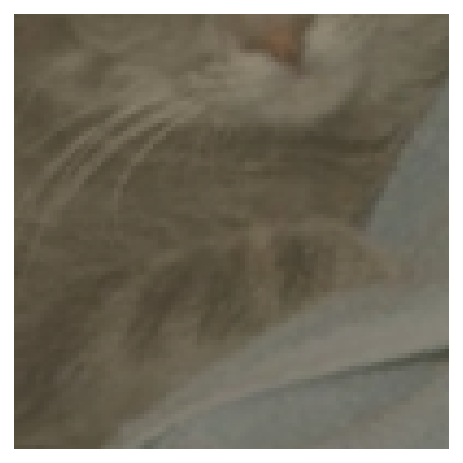

In [51]:
images, labels = next(iter(trainloader))
helper.imshow(images[0],normalize=True)

torch.Size([3, 100, 100])

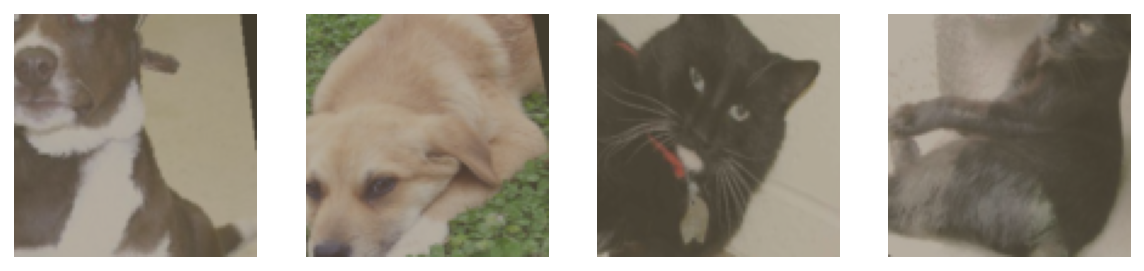

In [52]:
train_iter = iter(trainloader)

images, labels = next(train_iter)
fig, axes = plt.subplots(figsize=(10,4),ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii],ax=ax)

images[0].shape

torch.Size([64, 3, 100, 100])

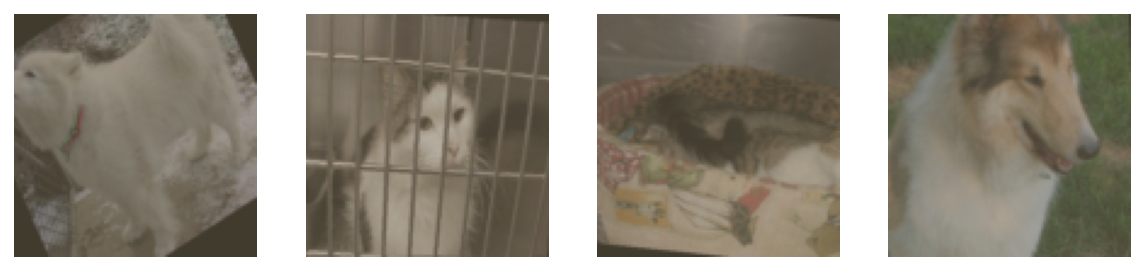

In [53]:
test_iter = iter(testloader)

images, labels = next(test_iter)
fig, axes = plt.subplots(figsize=(10,4),ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii],ax=ax)

images.shape

In [54]:
images.shape[0]
labels.shape[0]

64

In [55]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):

    def __init__(self,input_size,output_size,hidden_layers,drop_p=0.5):

        super().__init__()

        self.hidden_layers = nn.ModuleList([nn.Linear(input_size,hidden_layers[0])])

        layer_sizes = zip(hidden_layers[:-1],hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1,h2) for  h1,h2 in layer_sizes])

        self.output = nn.Linear(hidden_layers[-1],output_size)

        self.dropout = nn.Dropout(p=drop_p)

    def forward(self,x):

        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)

        x = self.output(x)

        return  F.log_softmax(x,dim=1)

In [56]:
from torch import optim
model = Network(100 * 100 * 3 ,2,[516,256], drop_p = 0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
def validation(model,testloader,criterion):

    test_loss = 0
    accuracy = 0

    for images, labels in testloader:

        images.resize_(images.shape[0],100 * 100 * 3)

        output = model.forward(images)
        test_loss += criterion(output,labels).item()

        ps = torch.exp(output)

        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [58]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    for images,labels in trainloader:
        steps += 1

        images.resize_(images.shape[0],100 * 100 * 3)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output,labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:

            model.eval() # we do not want drop out on while on validation

            with torch.no_grad():
                test_loss,accuracy = validation(model,testloader,criterion)


            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

            running_loss = 0

            model.train() # turn drop out back on

Epoch: 1/2..  Training Loss: 1.617..  Test Loss: 0.993..  Test Accuracy: 0.547


KeyboardInterrupt: 

In [ ]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')